In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt

import opentnsim.core

# Compute the node coordinates
We'll create the node coordinates. Those can be used to create a table of nodes and we can connect them in a circle to create edges. Now we'll follow the approach numpy arrays -> 2 tables (nodes, edges) -> graph. We could also start with the graph, for example using `nx.circulant_graph`. 

In [2]:
# make nodes (12 nodes, like a clock)
n_nodes = 12
radians = np.linspace(0, np.pi * 2, num=12, endpoint=False)
# coordinates for each node
x = np.cos(radians)
y = np.sin(radians)
x, y

(array([ 1.00000000e+00,  8.66025404e-01,  5.00000000e-01,  6.12323400e-17,
        -5.00000000e-01, -8.66025404e-01, -1.00000000e+00, -8.66025404e-01,
        -5.00000000e-01, -1.83697020e-16,  5.00000000e-01,  8.66025404e-01]),
 array([ 0.00000000e+00,  5.00000000e-01,  8.66025404e-01,  1.00000000e+00,
         8.66025404e-01,  5.00000000e-01,  1.22464680e-16, -5.00000000e-01,
        -8.66025404e-01, -1.00000000e+00, -8.66025404e-01, -5.00000000e-01]))

# Create the tables with nodes and edges
Create a table (dataframe) for both the nodes and the edges. Each row in the table is a node or an edge.

In [3]:
# Create a graph representing the pond
edges = []
nodes = []
# Loop over all the nodes
for i, (rad, x_i, y_i) in enumerate(zip(radians, x, y)):
    start = i
    # Are we at the end node?
    # then we need to close the loop
    if i == (n_nodes - 1):
        end = 0
    else:
        end = i + 1
        
    # an edge consists of a start node 
    edge = {
        "source": start, 
        "target": end,
        "e": (start, end),
        "rad": rad,
    }
    node = {
        "x": x_i,
        "y": y_i,
        "n": i,
        "geometry": shapely.geometry.Point(x_i, y_i)
    }
    edges.append(edge)
    nodes.append(node)
edges_df = pd.DataFrame(edges)
nodes_df = pd.DataFrame(nodes)


# Geocode
We now have the geometry column for nodes. If we also add a geometry column to the edges table, then we can convert the table to a geodataframe so that we can use spatial operations (distances).  

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



<AxesSubplot:>

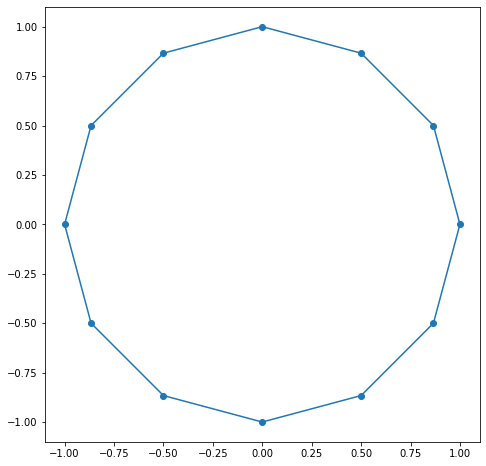

In [4]:
# the node

# create two temporary columns with the start end end geometry
edges_df['source_geometry'] = nodes_df['geometry'][edges_df['source']].reset_index(drop=True)
edges_df['target_geometry'] = nodes_df['geometry'][edges_df['target']].reset_index(drop=True)
# for each edge combine start and end geometry into a linestring (line)
edges_df['geometry'] = edges_df.apply(
    lambda row: shapely.geometry.LineString([row['source_geometry'], row['target_geometry']]), 
    axis=1
)
edges_df = edges_df.drop(columns=['source_geometry', 'target_geometry'])

nodes_gdf = gpd.GeoDataFrame(nodes_df)
edges_gdf = gpd.GeoDataFrame(edges_df)
edges_gdf["length_m"] = edges_gdf["geometry"].apply(lambda geom: geom.length)

# This is the spatial figure
fig, ax = plt.subplots(figsize=(13, 8))
edges_gdf.plot(ax=ax)
nodes_gdf.plot(ax=ax)

# Network
Now we can convert the nodes and edges into a networkx network.

In [5]:
# convention is that we call our graph FG (fairway graph)
FG = nx.from_pandas_edgelist(edges_gdf, edge_attr=True)

In [6]:
# update all nodes with info from the nodes table
nodes_gdf.apply(lambda row: FG.nodes[row.n].update(row), axis=1);

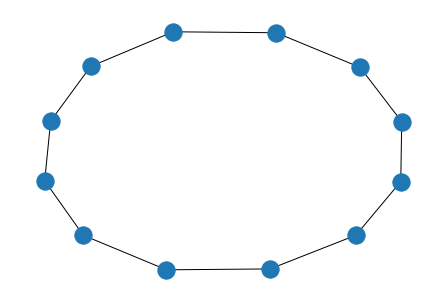

In [7]:
nx.draw(FG)